# Extracting star positions on a non-reference frame

## Import modules

In [76]:
from typing import List, Dict, Tuple
import requests, math, glob
import numpy as np
import pandas as pd
from astropy.stats import mad_std
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import Angle
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
from astropy.coordinates import match_coordinates_sky
from pathlib import Path
import re
from pathlib import Path
import utils
import os
from reading import ImageRecord
import do_calibration
import utils_sd
import subprocess
import logging
import time
os.chdir('/home/jovyan/work/src')

%load_ext autoreload
%autoreload 2
import reading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set reference frame, global vars


In [28]:
vastdir = '../inputfiles/ASASSN-V_J060000.76-310027.83/vast/2019_1_bestaper'
fitsdir  = '../inputfiles/ASASSN-V_J060000.76-310027.83/cleaned/2019'
savedir = '../'
PADDING = 200


In [29]:
import reading 
from collections import namedtuple

ref_jd, _, _, reference_frame = reading.extract_reference_frame(vastdir)
data, shapex, shapey = reading.get_fits_data(Path(fitsdir, Path(reference_frame).name))
starid = 174
image_records, rotation_dict = reading.get_xy_for_star_jd(starid, vastdir)
    
def check_star_is_in_ref_frame(image: ImageRecord):
    return (image.x < 0 or image.x > shapex or image.y < 0 or image.y > shapey) 

print("shapexy: ", shapex, shapey)
print("refjd, ref frame:", ref_jd, reference_frame)    
# for image in image_records:
#     print(check_star_is_in_ref_frame(image), image)
    
print("rotation dict has", len(rotation_dict), "entries")
print("imagerecords has", len(image_records), "entries")
sorted_images = sorted(image_records, key=lambda x: x.jd)
df = pd.DataFrame(image_records)
print(len(df))
df = df[(df.x > 0) & (df.x < shapex) & (df.y > 0) & (df.y < shapey)]
df['xdiff'] = abs(shapex/2 - df.x)
df['ydiff'] = abs(shapey/2 - df.y)
df['multi'] = df.xdiff + df.ydiff
print(df['multi'].idxmin())
print(df.iloc[df['multi'].idxmin()])
print(len(df))
chosen_row = df.iloc[df['multi'].idxmin()] 
chosen_jd = chosen_row.jd
chosen_record = ImageRecord(chosen_jd, chosen_row.x, chosen_row.y, chosen_row.file, chosen_row.rotation)
print(chosen_record)

shapexy:  1365 1365
refjd, ref frame: 2458836.58742 ../data/ASASSN-V_J060000.76-310027.83/cleaned/2019/ASASSN-V_060000.76-310027.83#60V_000783664_FLAT.fit
rotation dict has 749 entries
imagerecords has 735 entries
735
411
jd                                                2.45884e+06
x                                                         712
y                                                         142
file        ASASSN-V_060000.76-310027.83#60V_000789134_FLA...
rotation                                              180.022
xdiff                                                    29.5
ydiff                                                   540.5
multi                                                     570
Name: 411, dtype: object
735
ImageRecord(jd=2458842.65902, x=712, y=142, file='ASASSN-V_060000.76-310027.83#60V_000789134_FLAT.fit', rotation=180.022)


# TODO
- for each starid make in image with the star centered + cross around the star
- generate a list of UCAC4 in the vicinity and their star id


In [68]:
jddict = reading.jd_to_fitsfile_dict(vastdir)
chosen_fits = jddict[chosen_jd]
chosen_fits_fullpath = Path(fitsdir, chosen_fits)
chosen_rotation = rotation_dict[chosen_fits]
print("chosen fits: ", chosen_fits, chosen_fits_fullpath, "rotation", chosen_rotation)

chosen fits:  ASASSN-V_060000.76-310027.83#60V_000789134_FLAT.fit ../inputfiles/ASASSN-V_J060000.76-310027.83/cleaned/2019/ASASSN-V_060000.76-310027.83#60V_000789134_FLAT.fit rotation 180.022


In [32]:
sds = utils_sd.construct_star_descriptions(vastdir, None)
star_catalog = do_calibration.create_star_descriptions_catalog(sds)

In [33]:
print(len(sds), len(star_catalog))

1523 1523


## Plot crop of fits for one star

In [65]:
# vsx catalog is bigger in this case than star_catalog, but if we switch then different stars can be
# matched with the same variable which is wrong.
#
# idx : integer array
# Indices into catalogcoord to get the matched points for each matchcoord. Shape matches matchcoord.
#
# sep2d : Angle
# The on-sky separation between the closest match for each matchcoord and the matchcoord. Shape matches matchcoord.
sd_dict = utils.get_localid_to_sd_dict(sds)
sd_174 = sd_dict[starid]
# skycoord: SkyCoord = do_calibration.create_generic_astropy_catalog(sd_174.coords)
# do_calibration.create_generic_astropy_catalog()
for neigh in range(2,10):
    idx, d2d, _ = match_coordinates_sky(sd_174.coords, star_catalog, nthneighbor=neigh)
    neighbor = sds[idx]
    print(neighbor.xpos, neighbor.ypos)


817.101 1286.137
822.208 1288.531
817.331 1312.245
804.544 1311.250
784.015 1306.997
838.035 1243.089
768.195 1342.603
877.871 1290.543


In [70]:
print(sds[idx], d2d)

local_id: 187, aavso_id: None, coords: <SkyCoord (ICRS): (ra, dec) in deg
    (89.95554023, -31.34985977)>, xy: 877.871, 1290.543, vmag: None, nr matches: 0, matches: {}, path: ../inputfiles/ASASSN-V_J060000.76-310027.83/vast/2019_1_bestaper/out00187.dat [0d02m14.1763s]
../inputfiles/ASASSN-V_J060000.76-310027.83/vast/2019_1_bestaper/new-image.fits


# plate solve the chosen frame

In [77]:
apikey = ''
output_file = Path(vastdir) / f'platesolve_{starid}.fits'
subprocess.Popen(f"python3 ../src/astrometry_api.py --apikey={apikey} "
                 f"--upload={chosen_fits_fullpath} --newfits={output_file} --private --no_commercial", shell=True)
while not os.path.isfile(output_file):
    logging.info(f"Waiting for the astrometry.net plate solve...")
    time.sleep(10)


KeyboardInterrupt: 

In [78]:
print(output_file)

../inputfiles/ASASSN-V_J060000.76-310027.83/vast/2019_1_bestaper/platesolve_174.fits


## Save the image

ImageRecord(jd=2458842.65902, x=712, y=142, file='ASASSN-V_060000.76-310027.83#60V_000789134_FLAT.fit', rotation=180.022)
65535.0


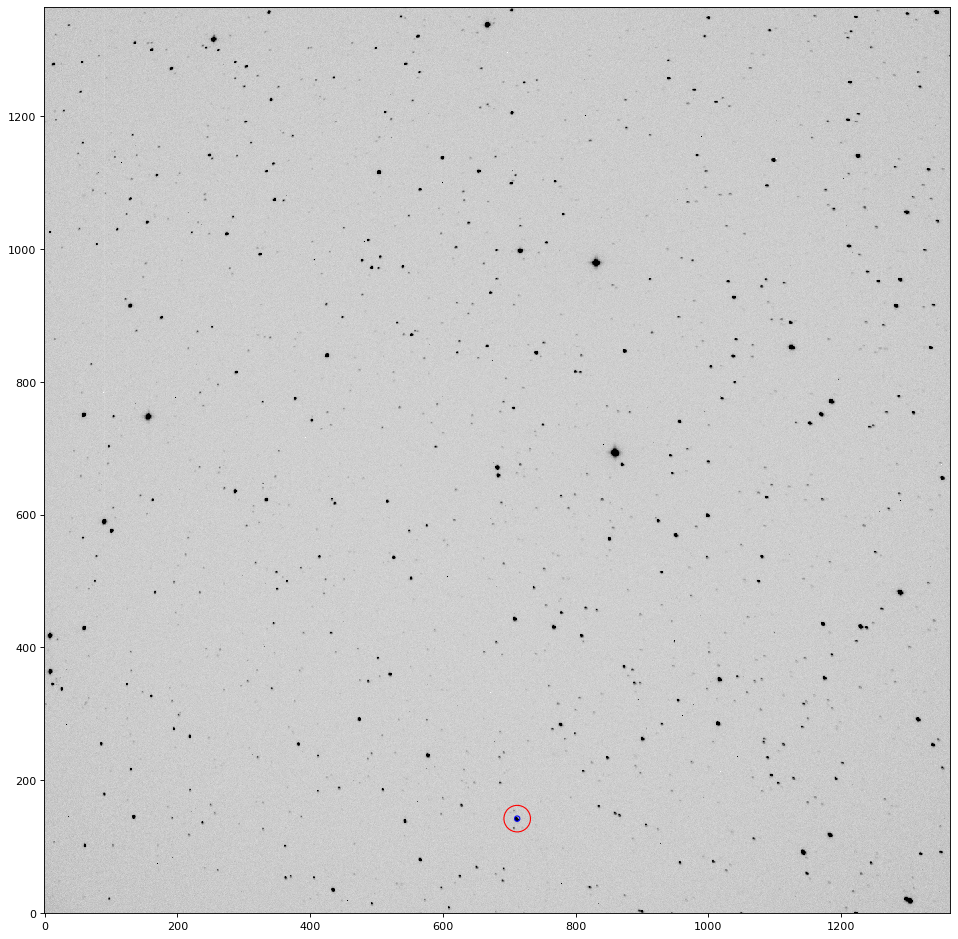

In [186]:
import glob
from tqdm import tqdm
from scipy import ndimage
from matplotlib.colors import LogNorm
padding = 0
dpi = 100


fig = plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
#ax = plt.axes()

import scipy.misc
from skimage.draw import line_aa

def draw_cross(data, record):
    x = record.y
    y = record.x
    rr, cc, val = line_aa(x-30, y, x-10, y)
    data[rr, cc] = val * 0
    rr, cc, val = line_aa(x+30, y, x+10, y)
    data[rr, cc] = val * 0
    rr, cc, val = line_aa(x, y-30, x, y-10)
    data[rr, cc] = val * data.max()
    rr, cc, val = line_aa(x, y+30, x, y+10)
    data[rr, cc] = val * data.max()
    return data

def update_img(record: ImageRecord):
    print(record)
    data, shapex, shapey = reading.get_fits_data(Path(fitsdir, record.file))
    backgr = data.mean()
    data = data.reshape(shapex, shapey)
    data = np.pad(data, (padding, padding), 'constant', constant_values=(backgr, backgr))

    #     data = draw_cross(data, record)

    target_app = CircularAperture((record.x, record.y), r=20.)    
    target_app.plot(color='r')
    target_app = CircularAperture((record.x, record.y), r=4.)    
    target_app.plot(color='b')

    rotx, roty = data.shape

    median = np.median(data)
    print(data.max())
    #     data = ndimage.interpolation.rotate(data, record.rotation)
    plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=min(median * 5, 65536))
    #ax.set_title(f"JD: {record.jd}")
update_img(chosen_record)
